# Self Consistent Field Iteration 

In this notebook we briefly introduce the scf iteration, in its most simplified form. 

We start by importing all the necessary files and fields to run the scf iteration.

In [1]:
include("../src/Atoms.jl")
include("../src/scfOptions.jl")
include("../src/Ham.jl")
include("../src/hartree_pot_bc.jl")
include("../src/pseudocharge.jl")
include("../src/getocc.jl")
include("../src/anderson_mix.jl")

using PyPlot

dx = 1.0;
Nunit = 32;
Lat = 10;
# using the default values in Lin's code
YukawaK = 0.0100
n_extra = 10; # QUESTION: I don't know where this comes from
epsil0 = 10.0;
T_elec = 100;

kb = 3.1668e-6;
au2K = 315774.67;
Tbeta = au2K / T_elec;


Ndist  = 1;   # Temporary variable
Natoms = round(Integer, Nunit / Ndist);

# Temp var, will be redefined by the size of R later.
R = zeros(Natoms, 1); # this is defined as an 2D array
for j = 1:Natoms
  R[j] = (j-0.5)*Lat*Ndist+dx;
end

Natoms = size(R)[1];
sigma  = ones(Natoms,1)*(2.0);  # insulator
omega  = ones(Natoms,1)*0.03;
Eqdist = ones(Natoms,1)*10.0;
mass   = ones(Natoms,1)*42000.0;
nocc   = ones(Natoms,1)*2;          # number of electrons per atom
Z      = nocc;
# creating an atom structure
atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc);

The scf iteration aims to solve the minimization problem given by
$$ \min_{\Psi^*\Psi = I \,\, \text{and} \, \,  \rho = diag(\Psi \Psi^*)} \Psi^* H[\rho] \Psi  $$

Where $H[\rho] \psi = \triangle \psi + \mathcal{V}_{\text{tot}}[\rho] \psi $. Which can be rewritten as a non-linear eigenvalue problem given by 

$$H[\rho] \Psi  = \Psi \Lambda, \,\, \text{s.t.} \,\, \rho = \text{diag}(\Psi \Psi^*) \,\, \text{and} \, \, \Psi^*\Psi = I $$

where $\Psi$ encodes the occupied orbitals, and $\Lambda$ encodes the energy levels. The scf iteration aims to solve the non-linear eigenvalue problem by solving a sequence of linear eigenvalue problem, and updating the density in a self consistent fashion. 

We define a Ham structure, which encapsulates the Hamiltonian, and we initialize it with a initial charge density. 

In [2]:
ham = Ham(Lat, Nunit, n_extra, dx, atoms, YukawaK, epsil0, Tbeta)

# total number of occupied orbitals
Nocc = round(Integer, sum(atoms.nocc) / ham.nspin);

# initialize the potentials within the Hemiltonian setting H[\rho_0]
init_pot!(ham, Nocc);

The scf iteration consists in several building blocks, which have many different knobs and buttons. Therefore, there exists a myriad of different options that will be explained in the sequel. Most of these options are encapsulated within a scfOptions struct. In particular the maximum number of iterations, the tolerance, and the algorithms for the linear eigenvalue problem and the update of the potential, commonly refered to as mixing. 

In [15]:
scfOpts = scfOptions();
@show scfOpts

scfOpts = scfOptions("anderson", 0.5, 10, 1.0e-7, 100, 1.0e-8, 100, "eigs")


scfOptions("anderson", 0.5, 10, 1.0e-7, 100, 1.0e-8, 100, "eigs")

The scf options are used to determine the different options within the scf iteration. In this case, we used two extra structures for the the inner level options. One encapsulates the options for the iterative linear eigensolver, and the second, encodes the information of the update of the potentials, given the update in the charge density. 

In [4]:
eigOpts = eigOptions(scfOpts);
mixOpts = andersonMixOptions(ham.Ns, scfOpts);

each SCF iteration can be distilled to the following three steps:

1) solve the linear eigenvalue problem
$$H[\rho_i] \Psi_i  = \Psi_i \Lambda_i,$$

2) update the electron density $\rho_{i+1},$
$$\rho_{i+1} = \text{diag} (\Psi_i*\Psi_i^*)$$

3) update the potential, using the new density, which in a more general form is given by
$$ \mathcal{V}_{\text{tot}}[\rho_{i+1},\rho_{i}],$$
used the updated total potential within the Hamiltonian 

$$ H[\rho_{i+1}] = \triangle +\mathcal{V}_{\text{tot}}[\rho_{i+1},\rho_{i}] $$
  
repeat.


Now we can start running the loop. The first step is to solve 
$$H[\rho_i] \Psi_i  = \Psi_i \Lambda_i,$$
which is performed using the update_psi! function. This function, acts on the Ham object, and it updates the structure.

In [5]:
update_psi!(ham, eigOpts);

We can have access to $\Psi_i$, by accessing the psi field, and we can have access to the diagonal of $\Lambda_i$ using the ev field within the Ham struct. 


In [6]:
Psi = ham.psi;
ev  = ham.ev;

In addition the Ham struct as been overloaded with multiplication by vector and matrices, then you can easily chec that ev are indeed the eigenvalues of $H[\rho_i]$

In [7]:
norm(Psi'*(ham*Psi) - diagm(ev))

2.602988604736501e-15

and that $\Psi$ have orthogonal colums

In [8]:
norm(Psi'*Psi - eye(size(Psi)[2]) ) 

8.850086390597894e-15

Now that the $\Psi_i$ have been updated we update the electron density. In this case we need the number of occupied orbital and a Ham class. 

In [9]:
update_rho!(ham,Nocc);

The function, updates $\rho$ inside the Ham structure, which can be easily accesed by ham.rho, and we can plot it using PyPlot. 

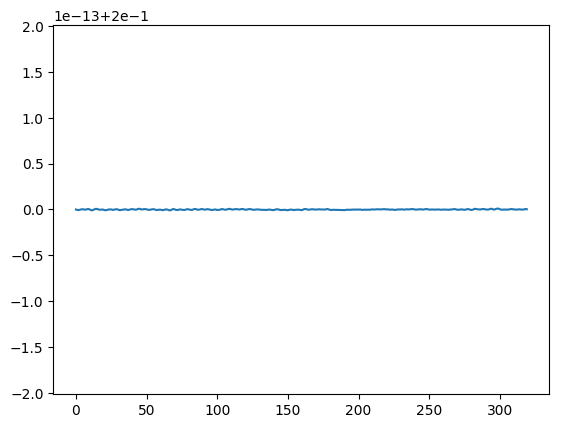

In [10]:
rho = ham.rho;
plot(rho);

Given that $\rho$ has been updated, we can proceed to update the potentials. 
This is indeed fairly tricky. A naive update will cause the iteration to diverge. We do not dwel in the details for the uddate, we refer the interested reader to the notebook on mixing for further details. 

However, we can say that the potential takes the form $\mathcal{V}_{\text{tot}}[\rho_{i+1}, \rho_{i}]$ such that when the iteration has converged we have that $\mathcal{V}_{\text{tot}}[\rho^*, \rho^*] = \mathcal{V}_{\text{tot}}[\rho^*]$. In this case, however, all the details are hidden in the update_vtot! function, which computes uses the new $rho$ to compute the new potential. (this has to be properly explained)

In [11]:
Verr = update_vtot!(ham, mixOpts)

4.811140113364092e15

In addition, the function provides a normalized step in the potential. (the first one is very big, because we are almost dividing by zero), we stop the iteration one the step in the potential is below a certain threshold (given in the scfOptions)

## SCF iteration

Then we are ready to properly implement the iteration, which is given by

In [12]:
for ii = 2:scfOpts.scfiter
    update_psi!(ham, eigOpts)
    
    update_rho!(ham,Nocc)
    
    Verr = update_vtot!(ham, mixOpts)
    println("Error in the ", ii, " iteration is ", Verr)
    if scfOpts.SCFtol > Verr
        break
    end
end

Error in the 2 iteration is 0.7783974164757314
Error in the 3 iteration is 0.12054144768959411
Error in the 4 iteration is 0.13559237789621179
Error in the 5 iteration is 0.015997828650747146
Error in the 6 iteration is 0.009890651881205517
Error in the 7 iteration is 0.001998010478160347
Error in the 8 iteration is 0.001748800641887528
Error in the 9 iteration is 0.0017110843410146394
Error in the 10 iteration is 0.0016609551989781178
Error in the 11 iteration is 0.0015997960706816527
Error in the 12 iteration is 0.001542120057110561
Error in the 13 iteration is 4.171298634323179e-5
Error in the 14 iteration is 1.1679059190981404e-5
Error in the 15 iteration is 1.1056902508344636e-7
Error in the 16 iteration is 1.2355548589682613e-7
Error in the 17 iteration is 4.9494366910524794e-8


Now we can for example see the charge density

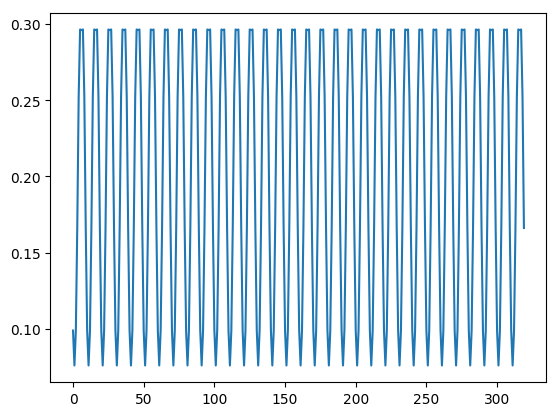

In [13]:
rho = ham.rho;
plot(rho);

Moreover, we can extract the density matrix.

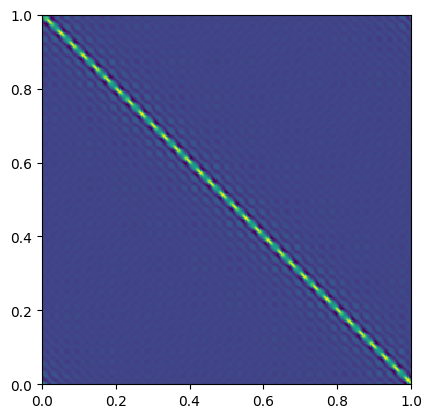

PyObject <matplotlib.image.AxesImage object at 0x1278546d0>

In [14]:
Psi = ham.psi;
P = Psi*Psi';
imshow(P, extent=[0, 1, 0, 1])